# Third-body perturbations

In this section, we will be formulating the third-body perturbations on an Earth-orbiting spacecraft with the help of the [VSOP2013](<./vsop2013.ipynb>) and [ELP2000](<./elp2000.ipynb>) analytical theories of motion.

## Theoretical background

We denote with $\mathbf{r}_P$, $\mathbf{r}_E$ and $\mathbf{r}_i$ the positions in an inertial reference frame of, respectively, an Earth-orbiting spacecraft, the Earth and a set of perturbers. Both the Earth and the perturbers are assumed to be point masses, the mass of the spacecraft is assumed to be negligible. The Newtonian gravitational acceleration of the spacecraft in the inertial frame can be written as:

$$
\ddot{\mathbf{r}}_P = -\frac{\mu_E\mathbf{r}_{EP}}{r_{EP}^3} - \sum_i{\frac{\mu_i\mathbf{r}_{iP}}{r_{iP}^3}},
$$

where $\mathbf{r}_{EP} = \mathbf{r}_P - \mathbf{r}_E$ and $\mathbf{r}_{iP} = \mathbf{r}_P - \mathbf{r}_i$ are the position vectors of the spacecraft with respect to, respectively, the Earth and the perturbers. $\mu_E$ and $\mu_i$ are the gravitational parameters of, respectively, the Earth and the perturbers.

If we assume that Earth's inertial acceleration $\ddot{\mathbf{r}}_E$ is due to the gravitational attraction of the perturbers, the geocentric acceleration of the spacecraft $\ddot{\mathbf{r}}_{EP}$ can be written as:

$$
\ddot{\mathbf{r}}_{EP}=\ddot{\mathbf{r}}_P-\ddot{\mathbf{r}}_E=-\frac{\mu_E\mathbf{r}_{EP}}{r_{EP}^3} - \sum_i{\left(\frac{\mu_i\mathbf{r}_{iP}}{r_{iP}^3} - \frac{\mu_i\mathbf{r}_{iE}}{r_{iE}^3}\right)},
$$

where $\mathbf{r}_{iE} = \mathbf{r}_E - \mathbf{r}_i$ is the position vector of the Earth with respect to the $i$-th perturber. Noting that $\mathbf{r}_{iP} = \mathbf{r}_{iE} + \mathbf{r}_{EP}$, we can then rewrite:

$$
\ddot{\mathbf{r}}_{EP}=-\frac{\mu_E\mathbf{r}_{EP}}{r_{EP}^3} - \sum_i{\mu_i\left(\frac{\mathbf{r}_{iE} + \mathbf{r}_{EP}}{\left|\mathbf{r}_{iE} + \mathbf{r}_{EP}\right|^3} - \frac{\mathbf{r}_{iE}}{r_{iE}^3}\right)}.
$$

This gives us the geocentric gravitational acceleration of the spacecraft as a function of the geocentric position vector $\mathbf{r}_{EP}$ and the $i$-centric position vector of the Earth.

For most applications, we can consider as perturbing bodies the Sun ($i=0$) and the Moon ($i=1$). Both $\mathbf{r}_{0E}$ and $\mathbf{r}_{1E}$ can be obtained from the [VSOP2013](<./vsop2013.ipynb>) and [ELP2000](<./elp2000.ipynb>) theories. If we also want to account for planetary perturbations, the planet-centric position vectors of the Earth $\mathbf{r}_{iE}$ can also be obtained from the VSOP2013 theory.

## Formulating the perturbing acceleration

We begin by importing the main modules and setting up a few constants:

In [1]:
import heyoka as hy
import numpy as np

# Gravitational parameters. See:
# https://iau-a3.gitlab.io/NSFA/NSFA_cbe.html
muS = 1.32712440041e20
muE = 3.986004356e14
muM = 4.902800145e12

# Earth/Moon mass ratio.
mu_star = muE / muM

# AU in meters.
AU = 149597870700.0

# Seconds in a day.
sday = 86400.0
# Days in a century.
dcy = 36525.0
# Days in a millenium.
dmil = 365250.0

We will be using SI units throughout this section, with time counted in TDB seconds since the Julian date $2451545.0$. All position vectors are expressed with respect to the [ICRS](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_its_realizations).

Next, we proceed to write a function that will formulate the perturbing acceleration via heyoka.py's [expression system](<./The expression system.ipynb>).

Recall from the [VSOP2013](<./vsop2013.ipynb>) and [ELP2000](<./elp2000.ipynb>) tutorials that both theories consist of analytical series whose numerical coefficients decay exponentially. In each theory, a ``thresh`` parameter can be specified in order to truncate terms in the series smaller in magnitude than the selected threshold, trading accuracy for increased performance. Our function for the formulation of the perturbing acceleration will thus accept in input distinct threshold values for the VSOP2013 and ELP2000 theories, so that we will later be able to quantitatively assess the impact of truncation.

In [2]:
def acc_3rd_body(vsop2013_thresh: float, elp2000_thresh: float):
    # Introduce three variables to represent the geocentric position of the spacecraft.
    x, y, z = hy.make_vars("x", "y", "z")

    # Compute the heliocentric position of the Earth-Moon barycentre
    # (planet number 3 in the VSOP2013 theory).
    x0EMB, y0EMB, z0EMB = (
        np.array(
            hy.model.vsop2013_cartesian_icrf(
                3,
                # NOTE: change the time coordinate to count seconds
                # since J2000 TDB.
                hy.time / (sday * dmil),
                thresh=vsop2013_thresh,
            )[:3]
        )
        # NOTE: change the unit of measurement from AU to metres.
        * AU
    )

    # Compute the Moon-centric position of the Earth using the ELP2000 theory.
    x1E, y1E, z1E = (
        -np.array(
            # NOTE: the ELP2000 theory is formulated in the FK5@J2000 frame, which
            # is close to but not exactly the same as the ICRS. Apply a rotation to
            # express the Moon's coordinates in the ICRS.
            hy.model.rot_fk5j2000_icrs(
                hy.model.elp2000_cartesian_fk5(
                    # NOTE: change the time coordinate to count seconds
                    # since J2000 TDB.
                    hy.time / (sday * dcy),
                    thresh=elp2000_thresh,
                )
            )
        )
        # NOTE: change the unit of measurement from kilometres to metres.
        * 1000.0
    )

    # Compute Earth's heliocentric position.
    x0E = x0EMB + x1E / (1.0 + mu_star)
    y0E = y0EMB + y1E / (1.0 + mu_star)
    z0E = z0EMB + z1E / (1.0 + mu_star)

    # Compute the contributions from the Sun.
    x0P = x0E + x
    y0P = y0E + y
    z0P = z0E + z
    r0P_m3 = hy.sum([x0P**2, y0P**2, z0P**2]) ** (-1.5)
    r0E_m3 = hy.sum([x0E**2, y0E**2, z0E**2]) ** (-1.5)

    # Compute the contributions from the Moon.
    x1P = x1E + x
    y1P = y1E + y
    z1P = z1E + z
    r1P_m3 = hy.sum([x1P**2, y1P**2, z1P**2]) ** (-1.5)
    r1E_m3 = hy.sum([x1E**2, y1E**2, z1E**2]) ** (-1.5)

    # Compute Earth's acceleration due to the perturbers.
    acc_earth_x = -(muS * x0E * r0E_m3 + muM * x1E * r1E_m3)
    acc_earth_y = -(muS * y0E * r0E_m3 + muM * y1E * r1E_m3)
    acc_earth_z = -(muS * z0E * r0E_m3 + muM * z1E * r1E_m3)

    # Compute the spacecraft's acceleration due to the perturbers.
    acc_direct_x = -(muS * x0P * r0P_m3 + muM * x1P * r1P_m3)
    acc_direct_y = -(muS * y0P * r0P_m3 + muM * y1P * r1P_m3)
    acc_direct_z = -(muS * z0P * r0P_m3 + muM * z1P * r1P_m3)

    # Return the total perturbing acceleration.
    return np.array(
        [
            acc_direct_x - acc_earth_x,
            acc_direct_y - acc_earth_y,
            acc_direct_z - acc_earth_z,
        ]
    )

## Checking the implementation

In order to validate our implementation of third-body perturbations, we will be comparing it to an implementation based on the [JPL Horizons](https://ssd.jpl.nasa.gov/horizons/app.html#/) service, which uses the latest [JPL development ephemeris (DE)](https://en.wikipedia.org/wiki/Jet_Propulsion_Laboratory_Development_Ephemeris).

We begin by writing a function that will take in input a sequence of TDB Julian dates and a Cartesian geocentric position vector in the ICRS, and return the third-body accelerations at the specified position vector for the input dates. The function will use the [Astroquery](https://astroquery.readthedocs.io/en/latest/) package to compute Earth's positions with respect to the Sun and the Moon.

In [3]:
import typing


def acc_3rd_body_jpl(dates: typing.Iterable[float], pos: typing.Iterable[float]):
    from astroquery.jplhorizons import Horizons

    # HORIZONS queries:
    # - 10, 399 and 301 are the IDs of the Sun, Earth and Moon,
    # - the syntax 500@x means "the center of body x".

    # Position of the Earth wrt the Sun.
    q_sun_earth = Horizons("399", location="500@10", epochs=dates)

    # Position of the Earth wrt the Moon.
    q_moon_earth = Horizons("399", location="500@301", epochs=dates)

    # Fetch the positions in meters.
    x0E_jpl = (
        q_sun_earth.vectors(refplane="earth")["x"].quantity[:].value * 1.495978707e11
    )
    y0E_jpl = (
        q_sun_earth.vectors(refplane="earth")["y"].quantity[:].value * 1.495978707e11
    )
    z0E_jpl = (
        q_sun_earth.vectors(refplane="earth")["z"].quantity[:].value * 1.495978707e11
    )

    x1E_jpl = (
        q_moon_earth.vectors(refplane="earth")["x"].quantity[:].value * 1.495978707e11
    )
    y1E_jpl = (
        q_moon_earth.vectors(refplane="earth")["y"].quantity[:].value * 1.495978707e11
    )
    z1E_jpl = (
        q_moon_earth.vectors(refplane="earth")["z"].quantity[:].value * 1.495978707e11
    )

    # Compute the perturbing acceleration.
    x0P_jpl = x0E_jpl + pos[0]
    y0P_jpl = y0E_jpl + pos[1]
    z0P_jpl = z0E_jpl + pos[2]
    r0P_jpl = np.linalg.norm([x0P_jpl, y0P_jpl, z0P_jpl], axis=0)
    r0E_jpl = np.linalg.norm([x0E_jpl, y0E_jpl, z0E_jpl], axis=0)

    x1P_jpl = x1E_jpl + pos[0]
    y1P_jpl = y1E_jpl + pos[1]
    z1P_jpl = z1E_jpl + pos[2]
    r1P_jpl = np.linalg.norm([x1P_jpl, y1P_jpl, z1P_jpl], axis=0)
    r1E_jpl = np.linalg.norm([x1E_jpl, y1E_jpl, z1E_jpl], axis=0)

    acc_direct_x_jpl = -muS * x0P_jpl / r0P_jpl**3 - muM * x1P_jpl / r1P_jpl**3
    acc_direct_y_jpl = -muS * y0P_jpl / r0P_jpl**3 - muM * y1P_jpl / r1P_jpl**3
    acc_direct_z_jpl = -muS * z0P_jpl / r0P_jpl**3 - muM * z1P_jpl / r1P_jpl**3
    acc_direct_jpl = np.array([acc_direct_x_jpl, acc_direct_y_jpl, acc_direct_z_jpl])

    acc_earth_x_jpl = -muS * x0E_jpl / r0E_jpl**3 - muM * x1E_jpl / r1E_jpl**3
    acc_earth_y_jpl = -muS * y0E_jpl / r0E_jpl**3 - muM * y1E_jpl / r1E_jpl**3
    acc_earth_z_jpl = -muS * z0E_jpl / r0E_jpl**3 - muM * z1E_jpl / r1E_jpl**3
    acc_earth_jpl = np.array([acc_earth_x_jpl, acc_earth_y_jpl, acc_earth_z_jpl])

    return acc_direct_jpl - acc_earth_jpl

Next we define a range of TDB Julian dates and a geocentric positions (in LEO and GEO) at which we will be evaluating the third-body perturbations:

In [4]:
# Pick 30 dates regularly spaced within 50 years after J2000.
jd_range = np.linspace(2451545.0, 2451545.0 + 50 * 365.25, 30)

# Pick sample positions in LEO and GEO.
pos_leo = np.array([(6370 + 410) * 1000.0, 0.0, 0.0])
pos_geo = np.array([42164.0 * 1000, 0.0, 0.0])

We can now proceed to create a [compiled function](<./compiled_functions.ipynb>) for the evaluation of our implementation of the perturbing acceleration. We pick a threshold level of $10^{-9}$ for both theories, which results in a positional error of $\sim 100\mathrm{m}$ for the Moon and a few kilometres for the Sun (see the [VSOP2013](<./vsop2013.ipynb>) and [ELP2000](<./elp2000.ipynb>) tutorials):

In [5]:
acc_cf = hy.cfunc(
    acc_3rd_body(1e-9, 1e-9), hy.make_vars("x", "y", "z"), compact_mode=True
)

We are now ready to numerically evaluate both implementations:

In [6]:
# Compute the accelerations in LEO.
acc_leo = acc_cf(
    np.repeat(pos_leo, len(jd_range), axis=0).reshape((3, -1)),
    time=(jd_range - 2451545.0) * sday,
)
acc_leo_jpl = acc_3rd_body_jpl(jd_range, pos_leo)

# Compute the accelerations in GEO.
acc_geo = acc_cf(
    np.repeat(pos_geo, len(jd_range), axis=0).reshape((3, -1)),
    time=(jd_range - 2451545.0) * sday,
)
acc_geo_jpl = acc_3rd_body_jpl(jd_range, pos_geo)

We can then plot the difference in the computed accelerations over the range of Julian dates:

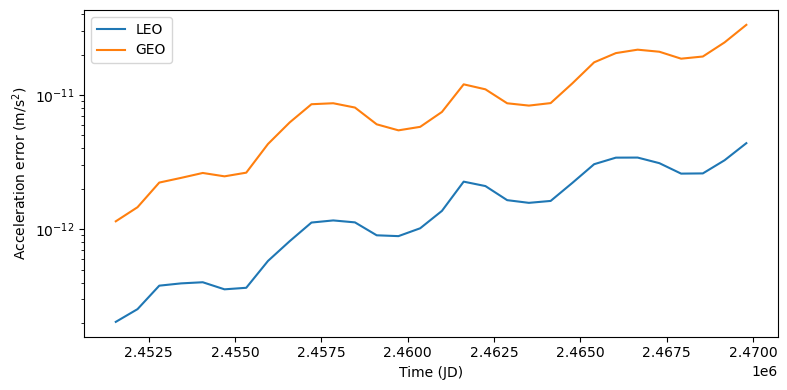

In [7]:
%matplotlib inline
from matplotlib.pylab import plt

# Compute the differences.
acc_diff_leo = np.linalg.norm(acc_leo - acc_leo_jpl, axis=0)
acc_diff_geo = np.linalg.norm(acc_geo - acc_geo_jpl, axis=0)

fig = plt.figure(figsize=(8, 4))

plt.semilogy(jd_range, acc_diff_leo, label="LEO")
plt.semilogy(jd_range, acc_diff_geo, label="GEO")
plt.xlabel("Time (JD)")
plt.ylabel(r"Acceleration error ($\mathrm{m}/\mathrm{s}^2)$")
plt.legend()
plt.tight_layout()

We can see how the error of our implementation is of the order of $10^{-12}\mathrm{m}/\mathrm{s}^2$ in LEO and $10^{-11}\mathrm{m}/\mathrm{s}^2$ in GEO. We can also see the error slowly increasing - this is expected as the accuracy of the VSOP2013 and ELP2000 theories slowly degrades with time.

As mentioned earlier, we can formulate the analytical theories at a lower level of accuracy by increasing the truncation threshold. Let us see how this affects the acceleration error:

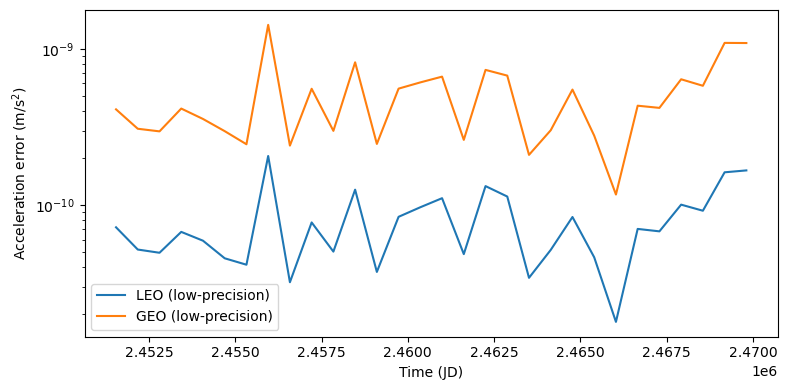

In [8]:
# Formulate a low-precision version of the acceleration.
acc_cf_lp = hy.cfunc(
    # NOTE: the thresholds are now 1e-3 (VSOP2013) and 1e-5 (ELP2000).
    acc_3rd_body(1e-3, 1e-5),
    hy.make_vars("x", "y", "z"),
    compact_mode=True,
)

# Evaluate numerically.
acc_leo_lp = acc_cf_lp(
    np.repeat(pos_leo, len(jd_range), axis=0).reshape((3, -1)),
    time=(jd_range - 2451545.0) * sday,
)
acc_geo_lp = acc_cf_lp(
    np.repeat(pos_geo, len(jd_range), axis=0).reshape((3, -1)),
    time=(jd_range - 2451545.0) * sday,
)

# Compute and plot the differences.
acc_diff_leo_lp = np.linalg.norm(acc_leo_lp - acc_leo_jpl, axis=0)
acc_diff_geo_lp = np.linalg.norm(acc_geo_lp - acc_geo_jpl, axis=0)

fig = plt.figure(figsize=(8, 4))

plt.semilogy(jd_range, acc_diff_leo_lp, label="LEO (low-precision)")
plt.semilogy(jd_range, acc_diff_geo_lp, label="GEO (low-precision)")
plt.xlabel("Time (JD)")
plt.ylabel(r"Acceleration error ($\mathrm{m}/\mathrm{s}^2)$")
plt.legend()
plt.tight_layout()

We can see how the lower-precision version of the computation is still able to deliver good acceleration errors.

## Use in numerical integrations

We can now proceed to show how third-body perturbations affect the orbit of a spacecraft. We begin by defining a baseline integrator to solve the Keplerian motion of the spacecraft with the help of {py:func}`~heyoka.model.fixed_centres()`:

In [9]:
# Keplerian dynamics for an Earth-orbiting spacecraft.
dyn_kep = hy.model.fixed_centres(masses=[muE], positions=[[0.0, 0.0, 0.0]])

# Integrator to solve Keplerian dynamics.
ta_kep = hy.taylor_adaptive(dyn_kep)

Next, we introduce a handy helper to construct an integrator to solve the Keplerian motion perturbed by third-body effects:

In [10]:
def make_3b_integrator(vsop2013_thresh: float, elp2000_thresh: float):
    # Baseline Keplerian dynamics.
    dyn = hy.model.fixed_centres(masses=[muE], positions=[[0.0, 0.0, 0.0]])

    # Compute and add the third-body accelerations.
    pert = acc_3rd_body(vsop2013_thresh, elp2000_thresh)
    dyn[3] = (dyn[3][0], dyn[3][1] + pert[0])
    dyn[4] = (dyn[4][0], dyn[4][1] + pert[1])
    dyn[5] = (dyn[5][0], dyn[5][1] + pert[2])

    # Build and return the integrator.
    return hy.taylor_adaptive(dyn, compact_mode=True)

And we build a high-accuracy integrator with thresholds of $10^{-9}$:

In [11]:
ta_ha = make_3b_integrator(1e-9, 1e-9)

As a first experiment, we can show how much third-body perturbations affect the position of the spacecraft after 1 day, in both LEO and GEO:

In [12]:
# Sample LEO and GEO initial state vectors.
ic_leo = [(6370 + 410) * 1000.0, 0.0, 0.0, 0.0, 7777.0, 0.0]
ic_geo = [42164.0 * 1000, 0.0, 0.0, 0.0, 3074.0, 0.0]

# Define a time grid over 1 day starting from J2000 TDB.
tspan = np.linspace(0, 86400.0, 1000)

# Propagate the Keplerian and perturbed dynamics.
ta_kep.state[:] = ic_leo
ta_kep.time = 0.0
res_kep_leo = ta_kep.propagate_grid(tspan)[-1]
ta_kep.state[:] = ic_geo
ta_kep.time = 0.0
res_kep_geo = ta_kep.propagate_grid(tspan)[-1]

ta_ha.state[:] = ic_leo
ta_ha.time = 0.0
res_ha_leo = ta_ha.propagate_grid(tspan)[-1]
ta_ha.state[:] = ic_geo
ta_ha.time = 0.0
res_ha_geo = ta_ha.propagate_grid(tspan)[-1]

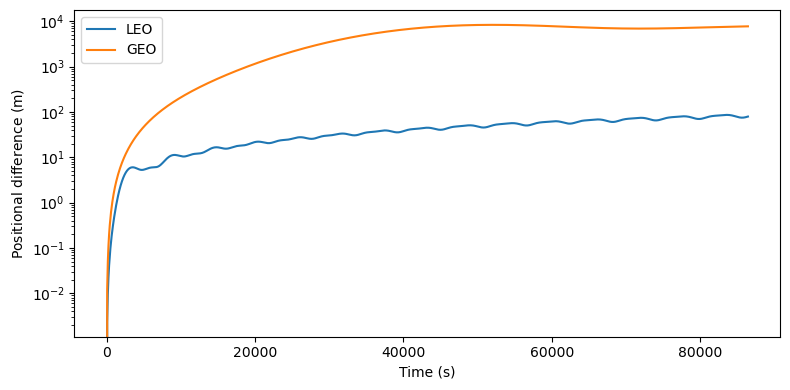

In [13]:
fig = plt.figure(figsize=(8, 4))

plt.semilogy(
    tspan, np.linalg.norm(res_kep_leo[:, :3] - res_ha_leo[:, :3], axis=1), label="LEO"
)
plt.semilogy(
    tspan, np.linalg.norm(res_kep_geo[:, :3] - res_ha_geo[:, :3], axis=1), label="GEO"
)

plt.xlabel("Time (s)")
plt.ylabel(r"Positional difference ($\mathrm{m})$")
plt.legend()
plt.tight_layout()

As expected, we can see how third-body perturbations have a much larger effect in GEO than in LEO due to the increased distance from Earth.

As a second experiment, we can study the error induced by lower truncation thresholds for the analytical theories. In order to do this, we will be constructing several integrators with different threshold combinations and compare the results to the high-accuracy integration.

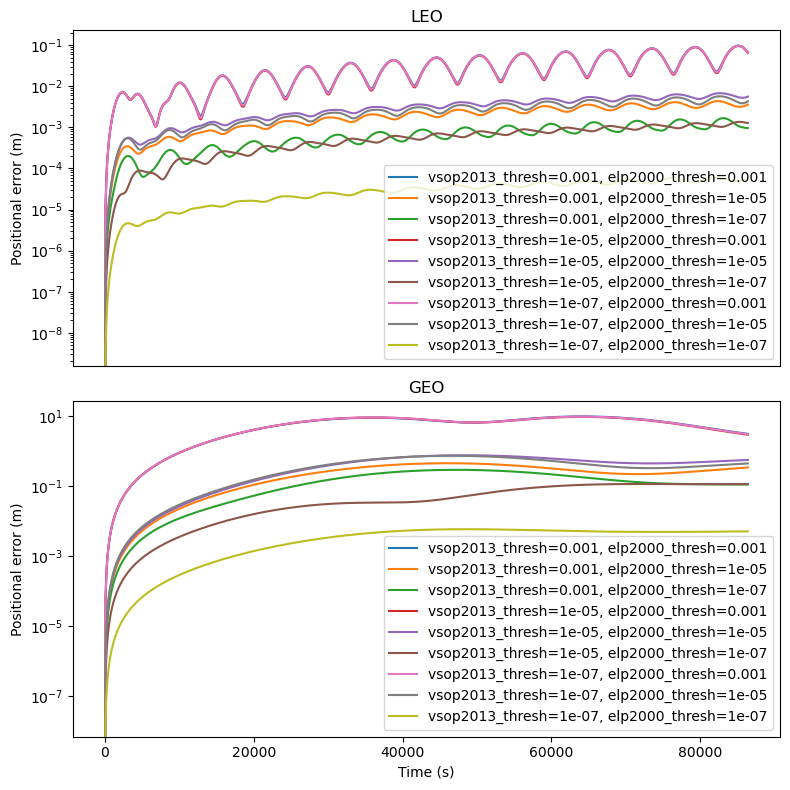

In [14]:
# Construct a grid of threshold values.
import itertools

thresh_list = list(itertools.product([1e-3, 1e-5, 1e-7], [1e-3, 1e-5, 1e-7]))


# Introduce a helper to plot the results of the comparisons between the high-precision
# integration and the lower-precision integrations.
def run_threshold_analysis(ic: typing.Iterable[float]):
    # Run the high-precision integration.
    ta_ha.state[:] = ic
    ta_ha.time = 0.0
    res_ref = ta_ha.propagate_grid(tspan)[-1]

    # Run the lower-precision integrations and plot the difference.
    for vsop2013_thresh, elp2000_thresh in thresh_list:
        ta = make_3b_integrator(vsop2013_thresh, elp2000_thresh)
        ta.state[:] = ic
        cur_res = ta.propagate_grid(tspan)[-1]

        plt.semilogy(
            tspan,
            np.linalg.norm(cur_res[:, :3] - res_ref[:, :3], axis=1),
            label=f"vsop2013_thresh={vsop2013_thresh}, elp2000_thresh={elp2000_thresh}",
        )


# Setup the plotting.
fig = plt.figure(figsize=(8, 8))

plt.subplot(211)
run_threshold_analysis(ic_leo)
plt.ylabel("Positional error (m)")
plt.xticks([])
plt.gca().set_title("LEO")
plt.legend()

plt.subplot(212)
run_threshold_analysis(ic_geo)
plt.xlabel("Time (s)")
plt.ylabel("Positional error (m)")
plt.gca().set_title("GEO")
plt.legend()

plt.tight_layout()

We can see how, as expected, the positional error with respect to the high-accuracy integration decreases with the threshold levels.

Of particular interest is the combination of threshold values $10^{-3}$ for VSOP2013 and $10^{-5}$ for ELP2000, which is able to keep the error around the millimetre level in LEO and decimetre level in GEO.